<a href="https://colab.research.google.com/github/santiagorg2401/pytorch_course_exercises/blob/main/02_neural_network_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 02. Neural Network Classification

## 0. Import libraries and set up devices

In [103]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt

from sklearn.datasets import make_circles, make_blobs
from sklearn.model_selection import train_test_split

try:
  from torchmetrics import Accuracy
except:
  !pip install torchmetrics
  from torchmetrics import Accuracy

import requests
from pathlib import Path
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download.")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary, plot_loss_curves

SEED = 42
TEST_SIZE = 0.2

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using PyTorch version {torch.__version__}")
print(f"Using Pytorch with {device}")

helper_functions.py already exists, skipping download.
Using PyTorch version 2.0.1+cu118
Using Pytorch with cuda


## 1. Prepare and load data

Shape X: torch.Size([1000, 2])
Shape y: torch.Size([1000])
First 5 samples of X:
tensor([[ 0.7542,  0.2315],
        [-0.7562,  0.1533],
        [-0.8154,  0.1733],
        [-0.3937,  0.6929],
        [ 0.4422, -0.8967]])
First 5 samples of y:
tensor([1., 1., 1., 1., 0.])
-------------------------------------------------------
Test set split size: 20%
Train shape -> X: torch.Size([800, 2]) y: torch.Size([800])
Test shape -> X: torch.Size([200, 2]) y: torch.Size([200])
-------------------------------------------------------



,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


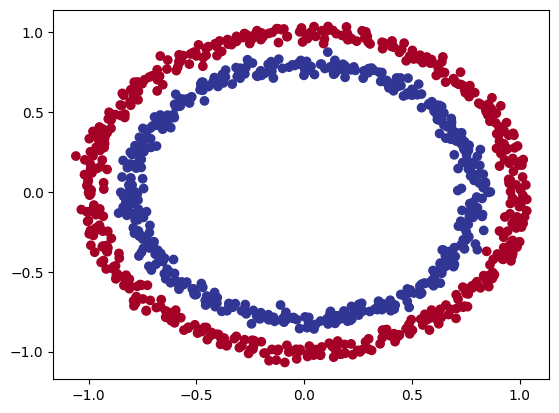

In [104]:
# Create 1000 circle samples
n_samples = 1000
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=SEED)

# Make a DataFrame
circles = pd.DataFrame({"X1":X[:,0],
                        "X2":X[:,1],
                        "label":y})

# Plot dataset
plt.scatter(X[:,0],
            X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu)

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split X, y into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=TEST_SIZE,
                                                    shuffle=True,
                                                    random_state=SEED)

# Send data into target device
X_train = X_train.to(device); X_test = X_test.to(device)
y_train = y_train.to(device); y_test = y_test.to(device)

# Print dataset info
m = f"Shape X: {X.shape}"\
    f"\nShape y: {y.shape}"\
    f"\nFirst 5 samples of X:\n{X[:5]}"\
    f"\nFirst 5 samples of y:\n{y[:5]}"\
    f"\n-------------------------------------------------------"\
    f"\nTest set split size: {int(TEST_SIZE*100)}%"\
    f"\nTrain shape -> X: {X_train.shape} y: {y_train.shape}"\
    f"\nTest shape -> X: {X_test.shape} y: {y_test.shape}"\
    f"\n-------------------------------------------------------"\
    f"\n"

print(m)

# Visualize DataFrame
circles.head()

## 2. `model_0` Binary classification with neural networks

### Build model class

In [105]:
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(in_features=2, out_features=8)
    self.layer2 = nn.Linear(in_features=8, out_features=1)

    """
    This also works:

    self.layers = nn.Sequential(
        nn.Linear(in_features=2, out_features=8),
        nn.Linear(in_features=8, out_features=1)
    )

    It is easier using sequential but the earlier is more beneficial for
    complex architectures.
    """

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    z = self.layer1(x)
    z = self.layer2(z)
    return z
    # return self.layers(x)

### Setup training and testing loop
The model outputs are called raw **logits**. These logits need to be converted into **prediction probabilities** by using an activation function and **prediction labels** by rounding or using argmax.

logits -> probabilities -> labels



In [106]:
EPOCHS = 100; LOG_STEP = 10; LEARNING_RATE = 1e-2

# Initialize model
torch.manual_seed(SEED); torch.cuda.manual_seed(SEED)
model_0 = CircleModelV0()
model_0 = model_0.to(device)

# Create experiment trackers
epoch_count = []
loss_values = []
accuracy_values = []
test_loss_values = []
test_accuracy_values = []

# Set up a loss function, optimizer and metric function
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=LEARNING_RATE)
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

for epoch in range(EPOCHS):
  # Training loop
  model_0.train()
  y_logits = model_0(X_train).squeeze(dim=1)
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, y_train)
  accuracy = accuracy_fn(y_train, y_pred)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Testing loop
  model_0.eval()
  with torch.inference_mode():
    test_logits = model_0(X_test).squeeze(dim=1)
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_accuracy = accuracy_fn(y_test, test_pred)

  # Log experiment data
  if epoch % LOG_STEP == 0 or epoch == EPOCHS - 1:
    epoch_count.append(epoch)
    loss_values.append(loss)
    accuracy_values.append(accuracy)
    test_loss_values.append(test_loss)
    test_accuracy_values.append(test_accuracy)

    m = f"Epoch: {epoch} | Loss: {loss:.5f} | Accuracy: {accuracy:.2f}%" \
        f"| Test loss: {test_loss:.5f} | Test accuracy: {test_accuracy:.2f}%"
    print(m)

results = {"train_loss": torch.tensor(loss_values).numpy(),
             "train_acc": accuracy_values,
             "test_loss": torch.tensor(test_loss_values).numpy(),
             "test_acc": test_accuracy_values}

Epoch: 0 | Loss: 0.70544 | Accuracy: 48.25%| Test loss: 0.69489 | Test accuracy: 53.00%
Epoch: 10 | Loss: 0.70482 | Accuracy: 48.25%| Test loss: 0.69443 | Test accuracy: 53.50%
Epoch: 20 | Loss: 0.70425 | Accuracy: 48.38%| Test loss: 0.69402 | Test accuracy: 54.00%
Epoch: 30 | Loss: 0.70372 | Accuracy: 48.25%| Test loss: 0.69365 | Test accuracy: 53.50%
Epoch: 40 | Loss: 0.70323 | Accuracy: 48.00%| Test loss: 0.69331 | Test accuracy: 53.00%
Epoch: 50 | Loss: 0.70278 | Accuracy: 48.00%| Test loss: 0.69301 | Test accuracy: 53.00%
Epoch: 60 | Loss: 0.70236 | Accuracy: 47.88%| Test loss: 0.69274 | Test accuracy: 53.00%
Epoch: 70 | Loss: 0.70196 | Accuracy: 48.25%| Test loss: 0.69250 | Test accuracy: 52.00%
Epoch: 80 | Loss: 0.70159 | Accuracy: 48.25%| Test loss: 0.69228 | Test accuracy: 52.50%
Epoch: 90 | Loss: 0.70125 | Accuracy: 48.25%| Test loss: 0.69209 | Test accuracy: 52.50%
Epoch: 99 | Loss: 0.70095 | Accuracy: 48.50%| Test loss: 0.69193 | Test accuracy: 53.00%


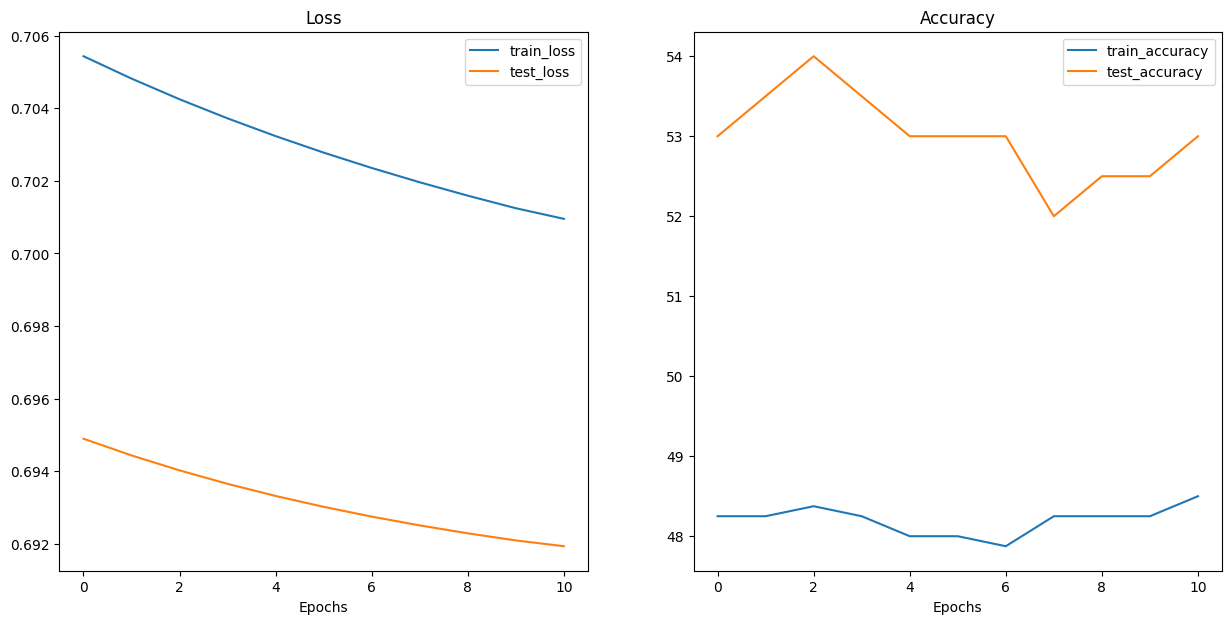

In [107]:
plot_loss_curves(results)

### Make predictions
It seems the model is almost not learning anything at all. This happens because there are only linear layers in the model.

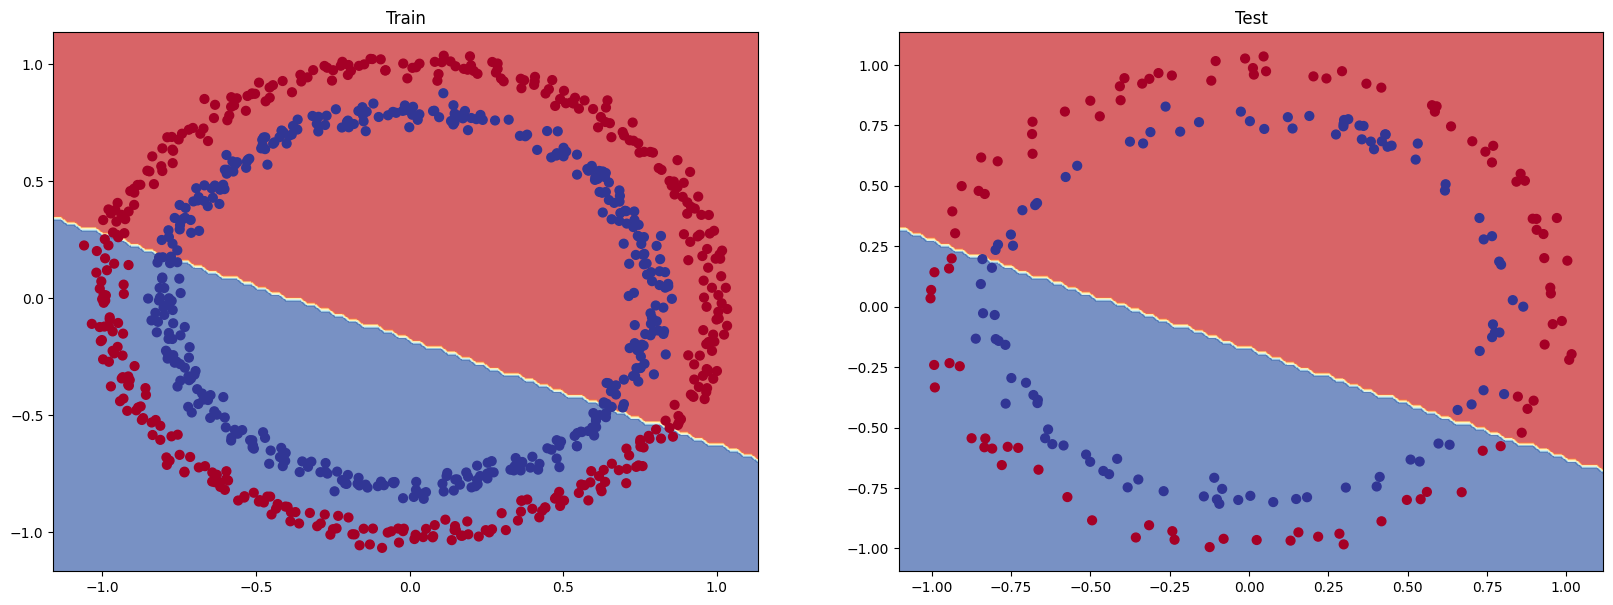

In [108]:
plt.figure(figsize=(20,7))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 3. `model_1` Improved model
From a model perspective, it can be improved by
* Adding more layers
* Adding more hidden units
* Fitting for longer
* Changing the activation functions
* Changing the learning rate
* Changing the loss function

### Build model class

In [109]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(in_features=2, out_features=16)
    self.layer2 = nn.Linear(in_features=16, out_features=16)
    self.layer3 = nn.Linear(in_features=16, out_features=1)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    # This way improves operation time
    return self.layer3(self.layer2(self.layer1(x)))

### Setup training and testing loop

In [110]:
EPOCHS = 1000; LOG_STEP = 100; LEARNING_RATE = 1e-2

# Initialize model
torch.manual_seed(SEED); torch.cuda.manual_seed(SEED)
model_1 = CircleModelV1()
model_1.to(device)

# Create experiment trackers
epoch_count = []
loss_values = []
accuracy_values = []
test_loss_values = []
test_accuracy_values = []

# Setup a loss function, an optimizer and a metrics function
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=LEARNING_RATE)
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

for epoch in range(EPOCHS):
  # Training loop
  model_1.train()
  y_logits = model_1(X_train).squeeze(dim=1)
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, y_train)
  accuracy = accuracy_fn(y_train, y_pred)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Testing loop
  model_1.eval()
  with torch.inference_mode():
    test_logits = model_1(X_test).squeeze(dim=1)
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_accuracy = accuracy_fn(y_test, test_pred)

  # Log experiment data
  if epoch % LOG_STEP == 0 or epoch == EPOCHS - 1:
    epoch_count.append(epoch)
    loss_values.append(loss)
    accuracy_values.append(accuracy)
    test_loss_values.append(test_loss)
    test_accuracy_values.append(test_accuracy)

    m = f"Epoch: {epoch} | Loss: {loss:.5f} | Accuracy: {accuracy:.2f}%" \
        f"| Test loss: {test_loss:.5f} | Test accuracy: {test_accuracy:.2f}%"
    print(m)

results = {"train_loss": torch.tensor(loss_values).numpy(),
             "train_acc": accuracy_values,
             "test_loss": torch.tensor(test_loss_values).numpy(),
             "test_acc": test_accuracy_values}

Epoch: 0 | Loss: 0.69618 | Accuracy: 50.00%| Test loss: 0.69372 | Test accuracy: 50.00%
Epoch: 100 | Loss: 0.69404 | Accuracy: 41.12%| Test loss: 0.69239 | Test accuracy: 44.00%
Epoch: 200 | Loss: 0.69349 | Accuracy: 47.12%| Test loss: 0.69247 | Test accuracy: 49.50%
Epoch: 300 | Loss: 0.69329 | Accuracy: 47.88%| Test loss: 0.69275 | Test accuracy: 49.50%
Epoch: 400 | Loss: 0.69318 | Accuracy: 48.75%| Test loss: 0.69303 | Test accuracy: 51.50%
Epoch: 500 | Loss: 0.69312 | Accuracy: 50.88%| Test loss: 0.69328 | Test accuracy: 47.50%
Epoch: 600 | Loss: 0.69308 | Accuracy: 52.00%| Test loss: 0.69349 | Test accuracy: 46.00%
Epoch: 700 | Loss: 0.69305 | Accuracy: 51.38%| Test loss: 0.69368 | Test accuracy: 46.50%
Epoch: 800 | Loss: 0.69303 | Accuracy: 51.00%| Test loss: 0.69383 | Test accuracy: 46.50%
Epoch: 900 | Loss: 0.69301 | Accuracy: 51.00%| Test loss: 0.69397 | Test accuracy: 47.00%
Epoch: 999 | Loss: 0.69300 | Accuracy: 51.12%| Test loss: 0.69408 | Test accuracy: 46.00%


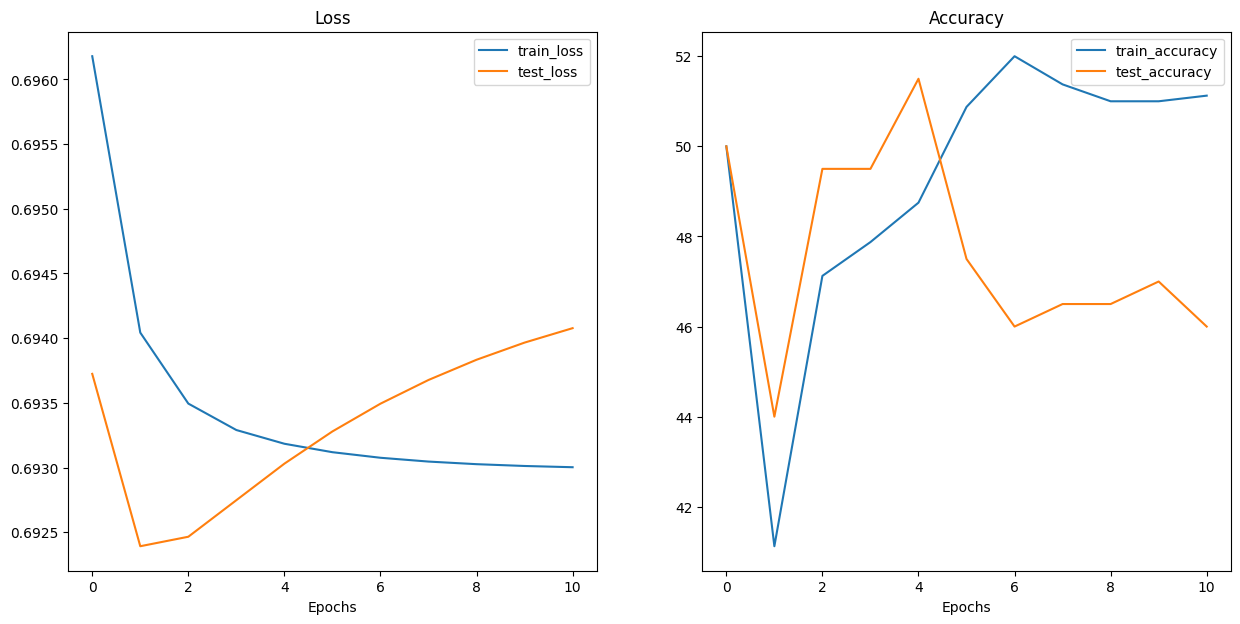

In [111]:
plot_loss_curves(results)

### Make predictions

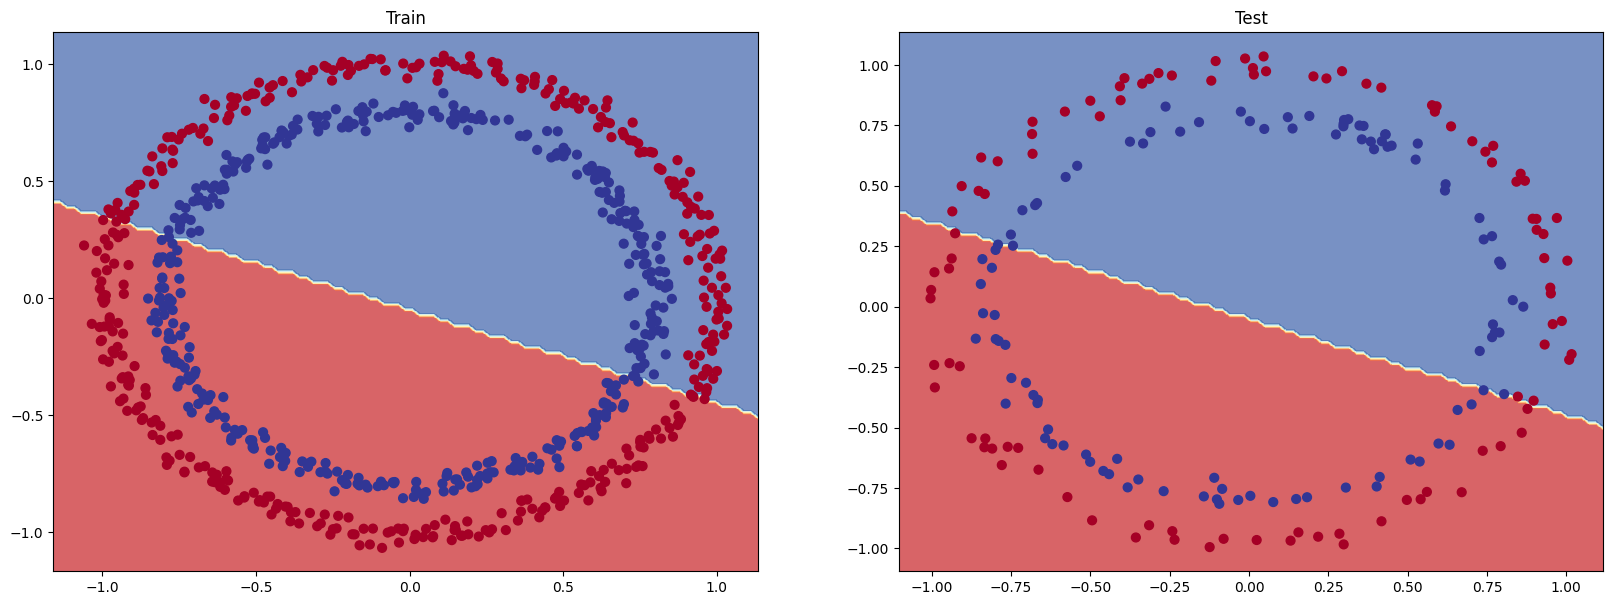

In [112]:
plt.figure(figsize=(20,7))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

### Test `model_1` on linear dataset to check if the model is learning

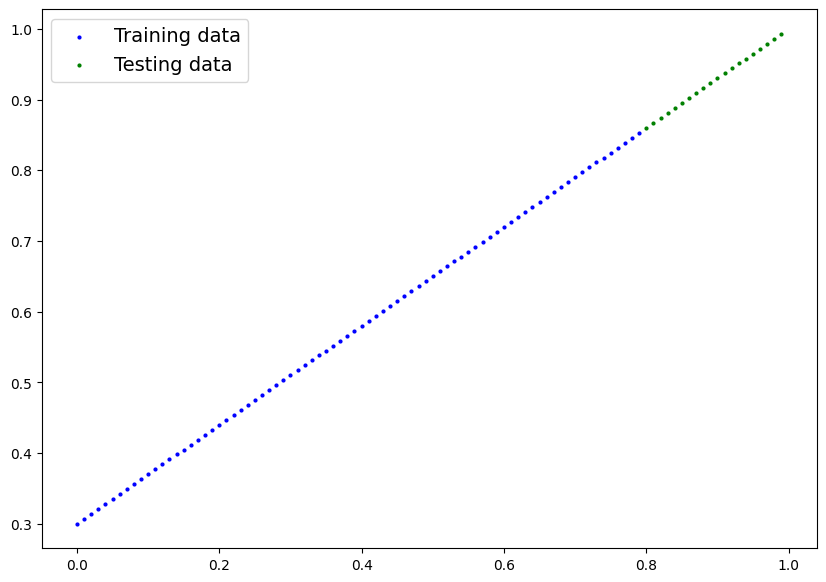

In [113]:
# Create synthetic dataset
WEIGHT = 0.7; BIAS = 0.3; START = 0; END = 1; STEP = 0.01
X_regression = torch.arange(START, END, STEP).unsqueeze(dim=1)
y_regression = WEIGHT * X_regression + BIAS

# Split dataset
X_train_regression, X_test_regression, y_train_regression, y_test_regression = train_test_split(X_regression,
                                                                                                y_regression,
                                                                                                test_size=TEST_SIZE,
                                                                                                shuffle=False)
# Plot dataset
plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data=X_test_regression,
                 test_labels=y_test_regression)

# Send dataset to target device
X_train_regression, X_test_regression = X_train_regression.to(device), X_test_regression.to(device)
y_train_regression, y_test_regression = y_train_regression.to(device), y_test_regression.to(device)

In [114]:
EPOCHS = 1000; LOG_STEP = 100; LEARNING_RATE = 1e-2
# Adjust model_1 input shape to 1
torch.manual_seed(SEED); torch.cuda.manual_seed(SEED)
model_1_regression = nn.Sequential(
    nn.Linear(in_features=1, out_features=16),
    nn.Linear(in_features=16, out_features=16),
    nn.Linear(in_features=16, out_features=1)
).to(device)

# Create experiment trackers
loss_values = []
mse_values = []
test_loss_values = []
test_mse_values = []

# Create a loss function, an optimizer and a metrics function
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_1_regression.parameters(),
                            lr=LEARNING_RATE)
def MSE(y_true, y_pred):
  return torch.square(torch.subtract(y_true, y_pred)).mean().item()

for epoch in range(EPOCHS):
  # Training loop
  model_1_regression.train()
  y_pred = model_1_regression(X_train_regression)

  loss = loss_fn(y_pred, y_train_regression)
  mse = MSE(y_train_regression, y_pred)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Testing loop
  model_1_regression.eval()
  with torch.inference_mode():
    test_pred = model_1_regression(X_test_regression)
    test_loss = loss_fn(test_pred, y_test_regression)
    test_mse = MSE(y_test_regression, test_pred)

  # Log experiment data
  if epoch % LOG_STEP == 0 or epoch == EPOCHS - 1:
    loss_values.append(loss)
    mse_values.append(mse)
    test_loss_values.append(test_loss)
    test_mse_values.append(test_mse)

    m = f"Epoch: {epoch} | Loss: {loss:.5f} | MSE: {mse:.5f}" \
        f"| Test loss: {test_loss:.5f} | Test MSE: {test_mse:.5f}"
    print(m)

results = {"train_loss": torch.tensor(loss_values).numpy(),
             "train_acc": mse_values,
             "test_loss": torch.tensor(test_loss_values).numpy(),
             "test_acc": test_mse_values}

Epoch: 0 | Loss: 0.44708 | MSE: 0.22718| Test loss: 0.69529 | Test MSE: 0.48495
Epoch: 100 | Loss: 0.02856 | MSE: 0.00110| Test loss: 0.12693 | Test MSE: 0.01616
Epoch: 200 | Loss: 0.03247 | MSE: 0.00135| Test loss: 0.11995 | Test MSE: 0.01443
Epoch: 300 | Loss: 0.03045 | MSE: 0.00126| Test loss: 0.11077 | Test MSE: 0.01231
Epoch: 400 | Loss: 0.03122 | MSE: 0.00133| Test loss: 0.10569 | Test MSE: 0.01122
Epoch: 500 | Loss: 0.03043 | MSE: 0.00126| Test loss: 0.10056 | Test MSE: 0.01015
Epoch: 600 | Loss: 0.02855 | MSE: 0.00112| Test loss: 0.09639 | Test MSE: 0.00933
Epoch: 700 | Loss: 0.02871 | MSE: 0.00109| Test loss: 0.09587 | Test MSE: 0.00923
Epoch: 800 | Loss: 0.02741 | MSE: 0.00100| Test loss: 0.09201 | Test MSE: 0.00850
Epoch: 900 | Loss: 0.02492 | MSE: 0.00085| Test loss: 0.08498 | Test MSE: 0.00725
Epoch: 999 | Loss: 0.03457 | MSE: 0.00163| Test loss: 0.00508 | Test MSE: 0.00004


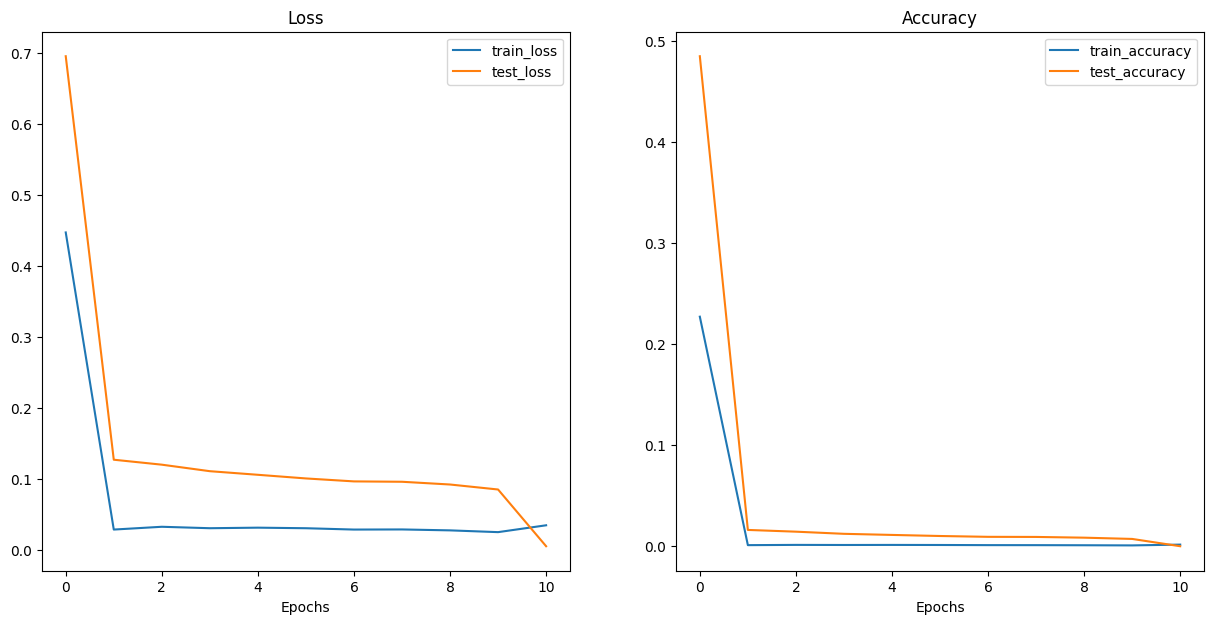

In [115]:
plot_loss_curves(results)

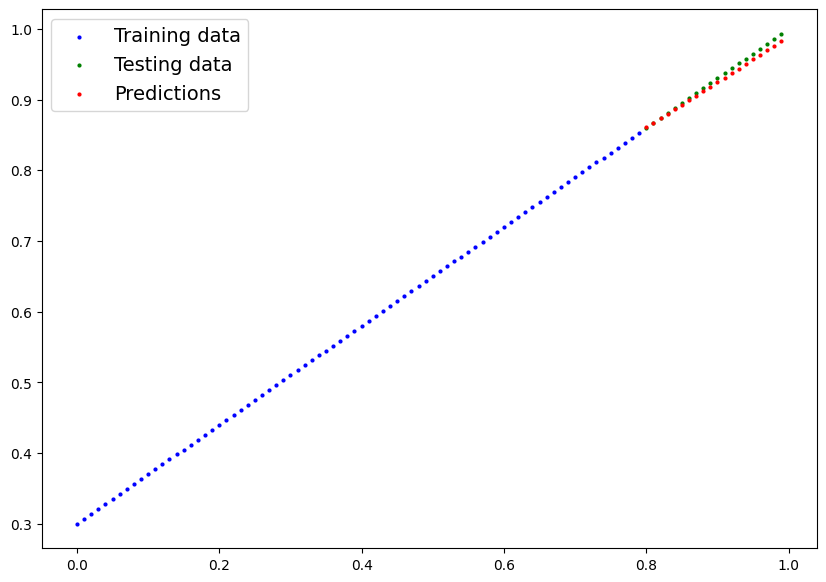

In [116]:
model_1_regression.eval()
with torch.inference_mode():
  preds = model_1_regression(X_test_regression)

plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=preds.cpu())

## 4. `model_2` Improve model by using non-linear activations

### Build model class

In [117]:
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.l1 = nn.Linear(in_features=2, out_features=16)
    self.l2 = nn.Linear(in_features=16, out_features=16)
    self.l3 = nn.Linear(in_features=16, out_features=1)
    self.relu = nn.ReLU()

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.l3(self.relu(self.l2(self.relu(self.l1(x)))))

### Setup training and testing loop

In [118]:
EPOCHS = 1000; LOG_STEP = 100; LEARNING_RATE = 1E-1

# Initialize the model
torch.manual_seed(SEED); torch.cuda.manual_seed(SEED)
model_2 = CircleModelV2()
model_2 = model_2.to(device)

# Create experiment trackers
loss_values = []; test_loss_values = []
accuracy_values = []; test_accuracy_values = []

# Create a loss function, an optimizer and a metrics function
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=LEARNING_RATE)
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

for epoch in range(EPOCHS):
  # Training loop
  model_2.train()
  y_logits = model_2(X_train).squeeze(dim=1)
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, y_train)
  accuracy = accuracy_fn(y_train, y_pred)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Testing loop
  model_2.eval()
  with torch.inference_mode():
    test_logits = model_2(X_test).squeeze(dim=1)
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_accuracy = accuracy_fn(y_test, test_pred)

  # Log experiment data
  if epoch % LOG_STEP == 0 or epoch == EPOCHS - 1:
    loss_values.append(loss)
    accuracy_values.append(accuracy)
    test_loss_values.append(test_loss)
    test_accuracy_values.append(test_accuracy)

    m = f"Epoch: {epoch} | Loss: {loss:.5f} | Accuracy: {accuracy:.2f}%" \
        f"| Test loss: {test_loss:.5f} | Test accuracy: {test_accuracy:.2f}%"
    print(m)

results = {"train_loss": torch.tensor(loss_values).numpy(),
             "train_acc": accuracy_values,
             "test_loss": torch.tensor(test_loss_values).numpy(),
             "test_acc": test_accuracy_values}

Epoch: 0 | Loss: 0.69753 | Accuracy: 50.00%| Test loss: 0.69784 | Test accuracy: 50.00%
Epoch: 100 | Loss: 0.68987 | Accuracy: 56.25%| Test loss: 0.69139 | Test accuracy: 51.50%
Epoch: 200 | Loss: 0.68663 | Accuracy: 52.88%| Test loss: 0.68875 | Test accuracy: 52.00%
Epoch: 300 | Loss: 0.68264 | Accuracy: 53.62%| Test loss: 0.68576 | Test accuracy: 52.50%
Epoch: 400 | Loss: 0.67735 | Accuracy: 54.00%| Test loss: 0.68189 | Test accuracy: 53.50%
Epoch: 500 | Loss: 0.67006 | Accuracy: 56.00%| Test loss: 0.67640 | Test accuracy: 55.50%
Epoch: 600 | Loss: 0.65938 | Accuracy: 62.38%| Test loss: 0.66777 | Test accuracy: 58.00%
Epoch: 700 | Loss: 0.64168 | Accuracy: 75.50%| Test loss: 0.65325 | Test accuracy: 68.50%
Epoch: 800 | Loss: 0.61284 | Accuracy: 87.38%| Test loss: 0.62886 | Test accuracy: 85.00%
Epoch: 900 | Loss: 0.56398 | Accuracy: 97.25%| Test loss: 0.58723 | Test accuracy: 93.00%
Epoch: 999 | Loss: 0.48323 | Accuracy: 99.25%| Test loss: 0.51787 | Test accuracy: 97.00%


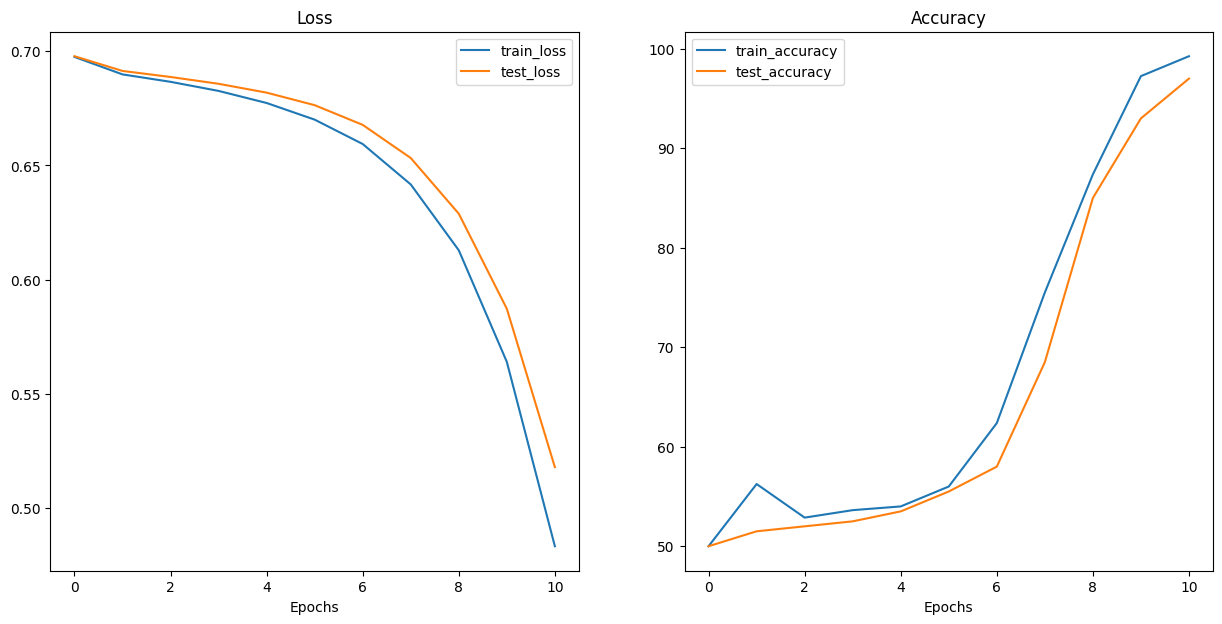

In [119]:
plot_loss_curves(results)

### Make predictions

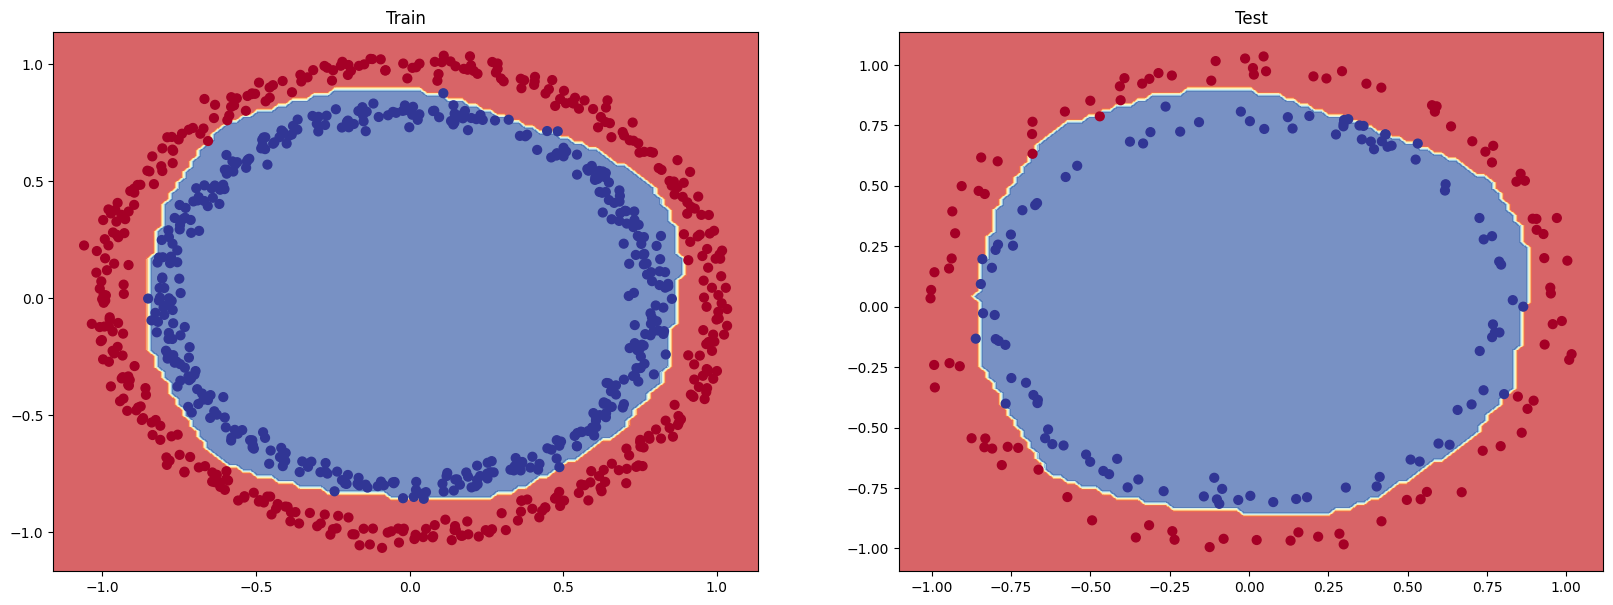

In [120]:
plt.figure(figsize=(20,7))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_2, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_2, X_test, y_test)

## 5. Replicating non-linear activation functions

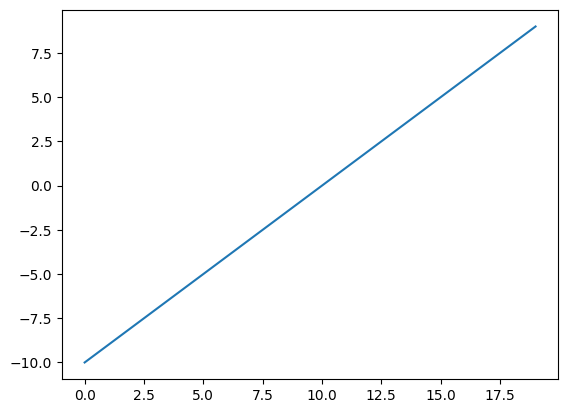

In [121]:
# Create and plot a tensor
A = torch.arange(-10, 10, 1, dtype=torch.float32)
plt.plot(A)

### ReLU

In [122]:
def relu(x) -> torch.Tensor:
  return torch.maximum(torch.tensor(0), x)

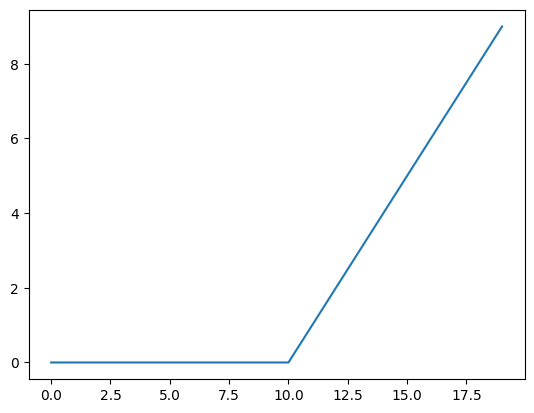

In [123]:
plt.plot(relu(A))

### Sigmoid

In [124]:
def sigmoid(x) -> torch.Tensor:
  return 1 / (1 + torch.exp(-x))

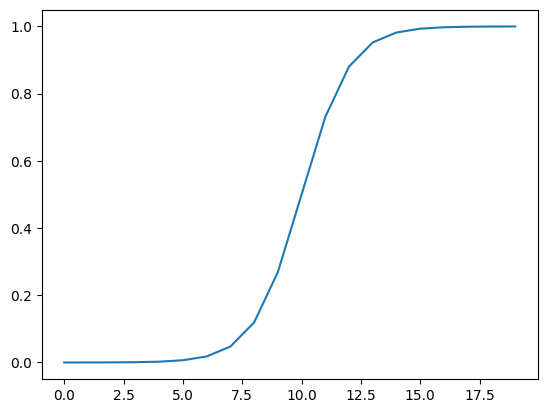

In [125]:
plt.plot(sigmoid(A))

## 6. Multi-class classification

### Prepare and load data

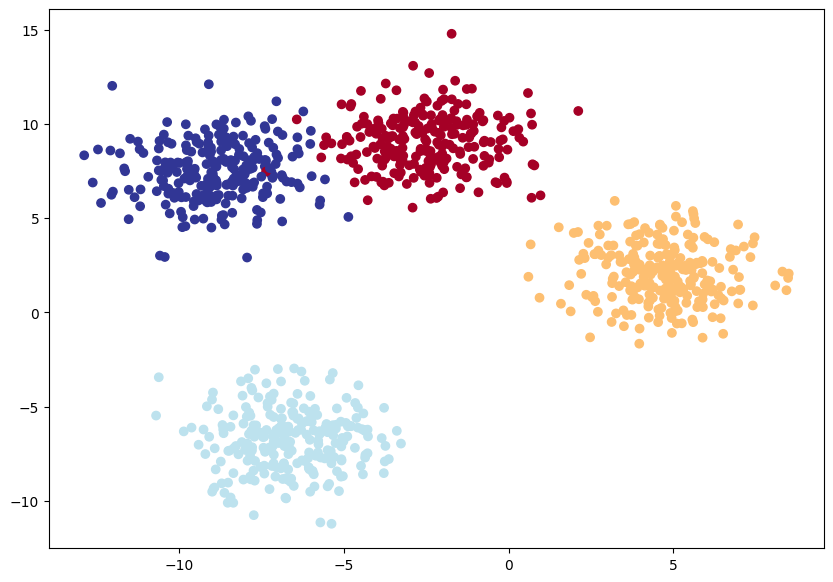

In [126]:
# Create multi-class classification toy dataset
N_CLASSES = 4; N_FEATURES= 2; N_SAMPLES = 1000

X_blob, y_blob = make_blobs(n_samples=N_SAMPLES,
                            n_features=N_FEATURES,
                            centers=N_CLASSES,
                            cluster_std=1.5,
                            random_state=SEED)

# Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# Split dataset into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=TEST_SIZE,
                                                                        shuffle=True,
                                                                        random_state=SEED)

# Visualize dataset
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:,0], X_blob[:,1], c=y_blob, cmap=plt.cm.RdYlBu)

# Send dataset to target device
X_blob_train = X_blob_train.to(device); X_blob_test = X_blob_test.to(device)
y_blob_train = y_blob_train.to(device); y_blob_test = y_blob_test.to(device)

### `model_3` Multi-class classification model

#### Build model class

In [127]:
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    """
    Initializes multi-class classification model.
    Args:
      input_features (int): Number of input features to the model
      output_features (int): Number of output features
      hidden_units (int): Number of hidden units between layers, default 8

    Returns:
    """
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(in_features=input_features,
                  out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,
                  out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,
                  out_features=output_features)
        )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.layers(x)

#### Setup training and testing loop

In [128]:
EPOCHS = 150; LOG_STEP = 10; LEARNING_RATE = 1E-2

# Initialize the model
torch.manual_seed(SEED); torch.cuda.manual_seed(SEED)
model_3 = BlobModel(input_features=2,
                    output_features=4,
                    hidden_units=8).to(device)

# Create experiment trackers
loss_values = []; test_loss_values = []
accuracy_values = []; test_accuracy_values = []

# Create a loss function, an optimizer and a metrics function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(),
                            lr=LEARNING_RATE)
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

for epoch in range(EPOCHS):
  # Training loop
  model_3.train()
  y_logits = model_3(X_blob_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  loss = loss_fn(y_logits, y_blob_train)
  accuracy = accuracy_fn(y_blob_train, y_pred)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Testing loop
  model_3.eval()
  with torch.inference_mode():
    test_logits = model_3(X_blob_test)
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

    test_loss = loss_fn(test_logits, y_blob_test)
    test_accuracy = accuracy_fn(y_blob_test, test_pred)

  # Log experiment data
  if epoch % LOG_STEP == 0 or epoch == EPOCHS - 1:
    loss_values.append(loss)
    accuracy_values.append(accuracy)
    test_loss_values.append(test_loss)
    test_accuracy_values.append(test_accuracy)

    m = f"Epoch: {epoch} | Loss: {loss:.5f} | Accuracy: {accuracy:.2f}%" \
        f"| Test loss: {test_loss:.5f} | Test accuracy: {test_accuracy:.2f}%"
    print(m)

results = {"train_loss": torch.tensor(loss_values).numpy(),
             "train_acc": accuracy_values,
             "test_loss": torch.tensor(test_loss_values).numpy(),
             "test_acc": test_accuracy_values}

Epoch: 0 | Loss: 1.15883 | Accuracy: 40.38%| Test loss: 1.14724 | Test accuracy: 38.50%
Epoch: 10 | Loss: 1.06493 | Accuracy: 55.38%| Test loss: 1.06841 | Test accuracy: 50.50%
Epoch: 20 | Loss: 0.98190 | Accuracy: 62.62%| Test loss: 0.99756 | Test accuracy: 57.50%
Epoch: 30 | Loss: 0.91139 | Accuracy: 70.50%| Test loss: 0.93600 | Test accuracy: 67.00%
Epoch: 40 | Loss: 0.85285 | Accuracy: 88.38%| Test loss: 0.88341 | Test accuracy: 87.50%
Epoch: 50 | Loss: 0.80430 | Accuracy: 92.12%| Test loss: 0.83851 | Test accuracy: 93.00%
Epoch: 60 | Loss: 0.76350 | Accuracy: 93.62%| Test loss: 0.79984 | Test accuracy: 94.50%
Epoch: 70 | Loss: 0.72848 | Accuracy: 94.88%| Test loss: 0.76595 | Test accuracy: 95.00%
Epoch: 80 | Loss: 0.69769 | Accuracy: 95.62%| Test loss: 0.73556 | Test accuracy: 95.00%
Epoch: 90 | Loss: 0.66978 | Accuracy: 96.38%| Test loss: 0.70758 | Test accuracy: 96.50%
Epoch: 100 | Loss: 0.64382 | Accuracy: 96.88%| Test loss: 0.68117 | Test accuracy: 97.00%
Epoch: 110 | Loss: 0.

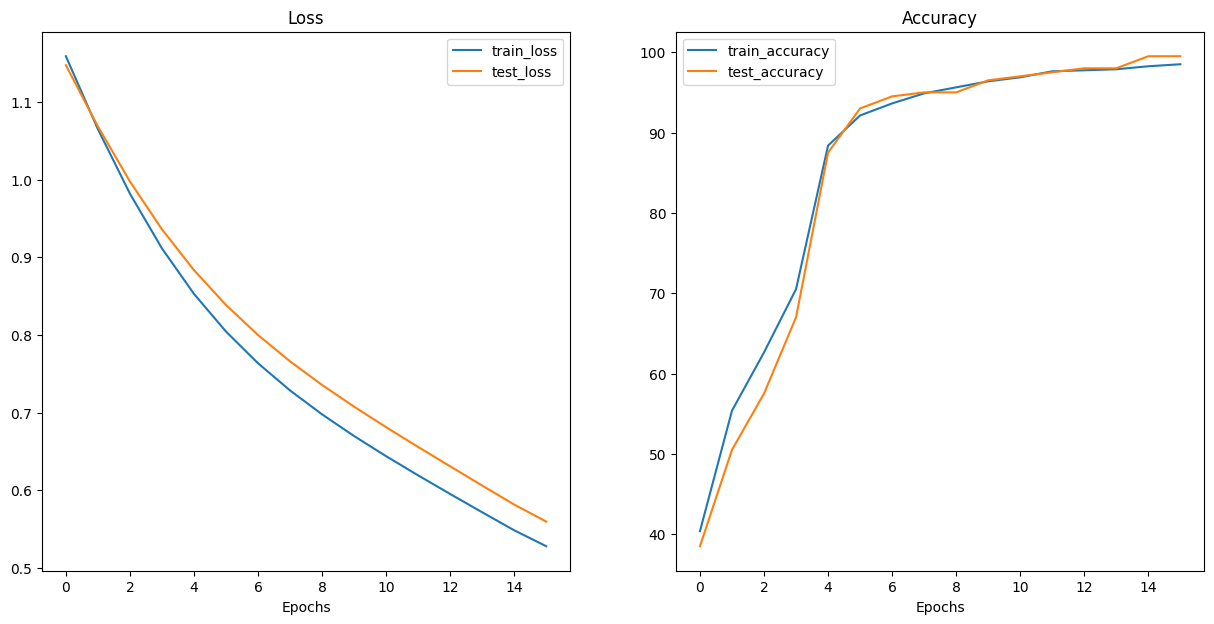

In [129]:
plot_loss_curves(results)

#### Make predictions

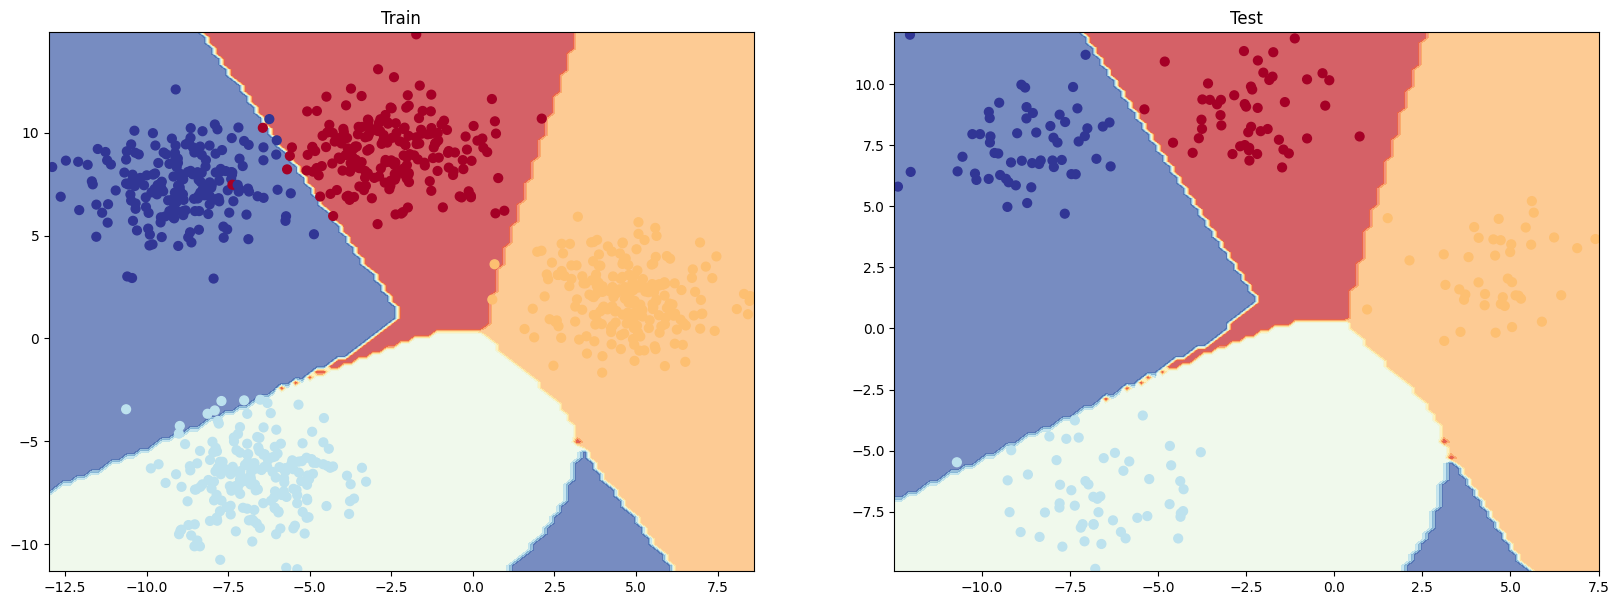

In [130]:
model_3.eval()
with torch.inference_mode():
  y_logits = model_3(X_blob_test)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

plt.figure(figsize=(20,7))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_blob_test, y_blob_test)

## 7. Try torchmetrics

In [131]:
torchmetric_accuracy = Accuracy(task="multiclass", num_classes=4).to(device)
torchmetric_accuracy(y_pred, y_blob_test)

tensor(0.9950, device='cuda:0')